# Analyzing NYC School Data - SAT Results

## Introduction & Purpose

The "SAT" (Scholastic Aptitude Test) is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it. The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points.Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

There is controversy around this test (and other standardized tests) though: are they unfair to certain groups?

In this study we will investigate correlations between SAT scores and demographics like race, gender, income, and more.

## Data
We will make us of data that is published by the City of New York. This includes SAT scores, demographic information and other data that is useful for our study. Here are the links to all of the data sets we'll be using:

SAT scores by school: SAT scores for each high school in New York City
School attendance: attendance information for each school in New York City
Class size: information on class size for each school
AP test results: Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
Graduation outcomes: The percentage of students who graduated, and other outcome information
Demographics: Demographic information for each school
School survey: Surveys of parents, teachers, and students at each school

## Contents
The remainder of the notebook contains the following sections:

Data preparations and cleaning
Overview of the data
Data analysis and visualization
SAT scores per boro and per district
Wrap-up and conclusions

## Data preparations and cleaning
In this section, we will first read in all the data, and do necessary data cleaning. Since all datasets are interrelated, we will combine them into a single dataset, that we can next use to find correlations.

Note: the code that follows next in this section is courtesy Dataquest. That is, during 'guided excercises' I actually did write the code to perform all the steps done below, but for convenience, for this notebook I have here reused (uncommented) code that was provided by Dataquest rather than copying all of my own code snippets. Some minor changes were made.

Further down there will be another marker to indicate till where this applies. After that marker, all code was written by me.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [9]:
# explore combined dataset
print(data['hs_directory'].columns)

Index(['dbn', 'school_name', 'boro', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'zip', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'priority05', 

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# import matplotlib + add line of code to plot charts in line
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [13]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


In [14]:
#filter correlations only for variables from suvery data
survey_correlations = correlations.loc[survey_fields]
print(survey_correlations.sort_values())

com_p_11     -0.115073
rr_t         -0.023386
eng_p_11      0.020254
aca_p_11      0.035155
eng_t_11      0.036906
rr_p          0.047925
com_tot_11    0.077310
com_t_11      0.082419
eng_tot_11    0.100102
saf_p_11      0.122913
aca_t_11      0.132348
com_s_11      0.187370
aca_tot_11    0.190966
eng_s_11      0.213822
rr_s          0.232199
N_t           0.291463
saf_t_11      0.313810
saf_tot_11    0.318753
saf_s_11      0.337639
aca_s_11      0.339435
N_p           0.421530
N_s           0.423463
Name: sat_score, dtype: float64


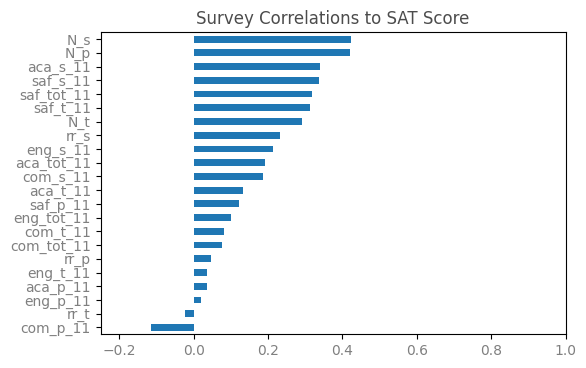

In [15]:
# plot bar chart
survey_correlations.sort_values().plot(kind='barh',sort_columns = True)
plt.xlim(-0.25,1)
plt.xticks(alpha=0.5)
plt.ylabel('')
plt.yticks(alpha=0.5)
plt.title('Survey Correlations to SAT Score',alpha=0.7)
plt.show()

Highest Correlations: 
- N_s (# of students responding)
- N_p (# of parents responding)
Seems like students & parents engagement has a relevant impact on SAT score, they are the only 2 over 0.4.
Students' expectations on Academic + Safty & respect score from students are also above 0.33
The other 2 variables above 0.3 are teachers's Safety score (saf_t_11) and Safety Total score (there might be some co-corrlation

To be noted that communication score based on parents (comp_p_11) is negatively correlated (-0.11)

## SAT Correlation with Safety

3 Safety Scores ranked in the top 6 (and above 0.3) correlated metrics, so we are going to dig deeper into this relationship

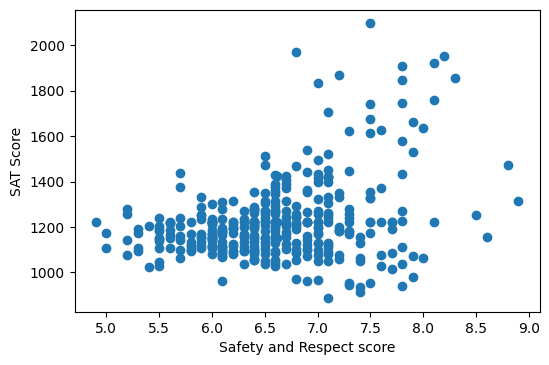

In [16]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('Safety and Respect score')
plt.ylabel('SAT Score')
plt.show()

In [17]:
borough_saf_pvt = pd.pivot_table(combined, values=['saf_s_11'], index=['boro'])
pd.pivot_table(combined, values=['saf_s_11','sat_score'], index=['boro'], )

,saf_s_11,sat_score
boro,,
Bronx,6.606577,1157.598203
Brooklyn,6.370755,1181.364461
Manhattan,6.831370,1278.331410
Queens,6.721875,1286.753032
Staten Island,6.530000,1382.500000


It looks like Manhattan and Queens are perceived safest, and Brooklyn least safe. Staten Island & Bronx seem to be outliers: Bronx is safest after Queens, but avg SAT is over 100 points below; while Staten Island is perceived as 2nd worst in Safety but has the highest avg score, ~100pts above both Manhattan & Queens both perceived as safest

## Correlations between SAT and Race

In [18]:
race_columns = ['white_per','asian_per','black_per','hispanic_per']
race_correlations = correlations.loc[race_columns]
print(race_correlations.sort_values())

hispanic_per   -0.396985
black_per      -0.284139
asian_per       0.570730
white_per       0.620718
Name: sat_score, dtype: float64


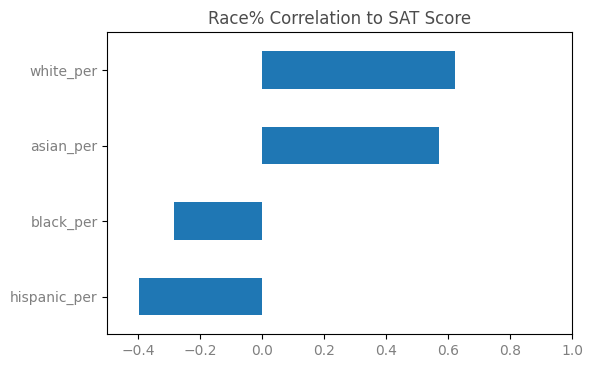

In [19]:
# plot bar chart
race_correlations.sort_values().plot(kind='barh',sort_columns = True)
plt.xlim(-0.5,1)
plt.xticks(alpha=0.5)
plt.ylabel('')
plt.yticks(alpha=0.5)
plt.title('Race% Correlation to SAT Score',alpha=0.7)
plt.show()

5 of Hispanic & Black students seem to have negative correlation with SAT scores, while White & Asian have strong positive correlations. Let's dig deeper into Hispanic.

### Hispanic% of students correlation vs SAT Score

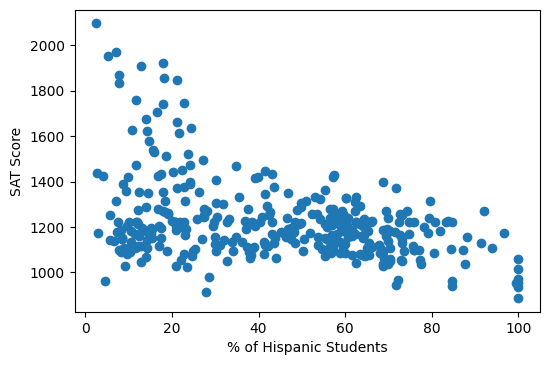

In [20]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.xlabel('% of Hispanic Students')
plt.ylabel('SAT Score')
plt.show()

Even Excluding the group of schools above 1500 avg SAT and below 30% Hispanic students, it does some negative correlation as the scatter plot gets denser over 50% Hispanic students and with very low scores for Hispanic only schools.

In [21]:
# reaserch schools with over 95% Hispanic per 
# and less than 10% + SAT above 1800
# 1 hispanic_over_95
hispanic_over_95 = combined[combined['hispanic_per']>= 95]
hispanic_over_95[['school_name','hispanic_per','sat_score']]

,school_name,hispanic_per,sat_score
44,Manhattan Bridges High School,99.8,1058.0
82,Washington Heights Expeditionary Learning School,96.7,1174.0
89,Gregorio Luperon High School for Science and M...,99.8,1014.0
125,Academy for Language and Technology,99.4,951.0
141,International School for Liberal Arts,99.8,934.0
176,Pan American International High School at Monroe,99.8,970.0
253,Multicultural High School,99.8,887.0
286,Pan American International High School,100.0,951.0


These schools seem to be targeted for Latinx/Hispanic students, potentially recently immigrated to the US?

In [22]:
hispanic_under_10 = combined[(combined['hispanic_per']<= 10) & (combined['sat_score']>=1800)]
hispanic_under_10[['school_name','hispanic_per','sat_score']].head()

,school_name,hispanic_per,sat_score
37,Stuyvesant High School,2.4,2096.0
151,Bronx High School of Science,7.2,1969.0
187,Brooklyn Technical High School,7.9,1833.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0
356,Staten Island Technical High School,5.3,1953.0


Schools with lower% of Hispanic Students seems to be technical/STEM oriented schools. We'd need to look into the the SAT breakdown to have a better nderstanding, but seems related to high SAT scores.

In [34]:
hispanic_under_10[['school_name','hispanic_per','sat_score','SAT Critical Reading Avg. Score','SAT Math Avg. Score','SAT Writing Avg. Score']].head()

,school_name,hispanic_per,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
37,Stuyvesant High School,2.4,2096.0,679.0,735.0,682.0
151,Bronx High School of Science,7.2,1969.0,632.0,688.0,649.0
187,Brooklyn Technical High School,7.9,1833.0,587.0,659.0,587.0
327,Queens High School for the Sciences at York Co...,7.9,1868.0,612.0,660.0,596.0
356,Staten Island Technical High School,5.3,1953.0,635.0,682.0,636.0


All these schools show at least 650 in the math section.

## Gender Analysis

In [24]:
gender_columns = ['male_per','female_per']
gender_correlations = correlations.loc[gender_columns]
print(gender_correlations.sort_values())

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


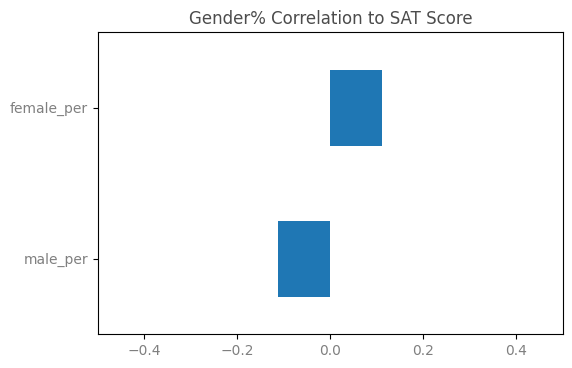

In [26]:
# plot bar chart
gender_correlations.sort_values().plot(kind='barh',sort_columns = True)
plt.xlim(-0.5,0.5)
plt.xticks(alpha=0.5)
plt.ylabel('')
plt.yticks(alpha=0.5)
plt.title('Gender% Correlation to SAT Score',alpha=0.7)
plt.show()

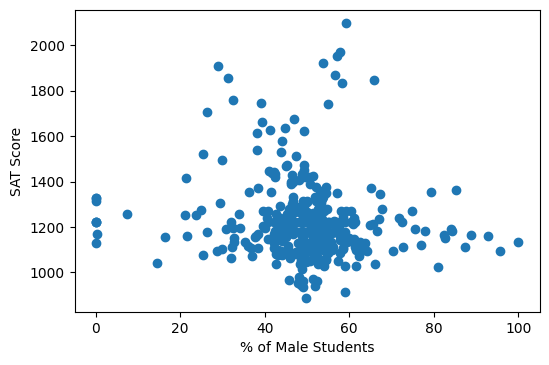

In [27]:
plt.scatter(combined['male_per'], combined['sat_score'])
plt.xlabel('% of Male Students')
plt.ylabel('SAT Score')
plt.show()

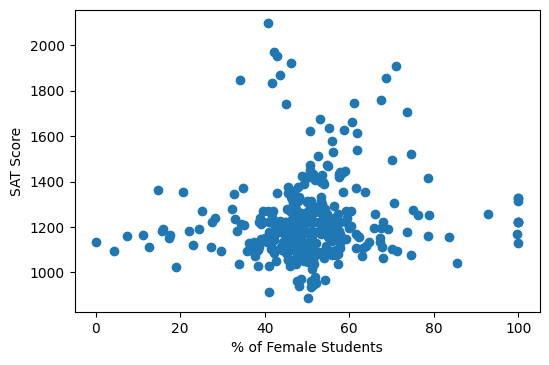

In [30]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.xlabel('% of Female Students')
plt.ylabel('SAT Score')
plt.show()

Female% is weakly associated with higher SAT score, there is an interesting group of schools above 1600 SAT and 60% of Female that is worth analyzing

In [33]:
female_60_sat_1700 = combined[(combined['sat_score']>= 1700) & (combined['female_per']>=60)]
female_60_sat_1700[['school_name','female_per','sat_score','asian_per','black_per','white_per','hispanic_per']].head()

,school_name,female_per,sat_score,asian_per,black_per,white_per,hispanic_per
5,Bard High School Early College,68.7,1856.0,15.1,15.1,49.8,18.2
26,Eleanor Roosevelt High School,67.5,1758.0,17.2,5.5,63.7,11.6
60,Beacon High School,61.0,1744.0,8.9,14.6,49.8,22.8
61,Fiorello H. LaGuardia High School of Music & A...,73.6,1707.0,19.6,12.9,49.2,16.6
302,Townsend Harris High School,71.1,1910.0,55.5,5.9,24.6,12.9


All these schools have a wikipedia page and are consistently ranked among top high schools in the entire US. They area all highly selective elite schools in their areas.
Although Black and Latino% is not high at any of these schools, Asians are majority at Townsend Harris High school, while they are in single digits at Beacon High.

## Advanced Placement Analysis

In [35]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

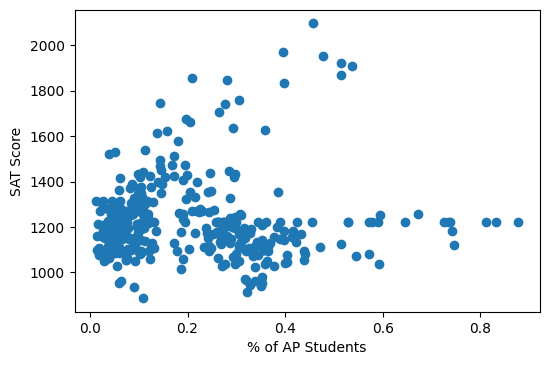

In [37]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel('% of AP Students')
plt.ylabel('SAT Score')
plt.show()

There seems to be 2 trends of schools: 
1. SAT increases with % of AP students, over 1500 SAT and 20%
2. Another group stable at 1200, over 40% AP takers

## Next Steps

### Neighborhood Analysis

In [47]:
#combined[['boro','school_dist','DBN','sat_score']].head()
combined['school_dist'].value_counts()

02    48
10    22
09    20
11    15
17    14
14    14
07    13
13    13
24    13
19    12
03    12
12    12
28    11
18    11
08    11
21    11
27    10
06    10
31    10
15     9
30     9
25     8
29     8
04     7
05     7
01     6
32     6
20     5
26     5
22     4
16     4
23     3
Name: school_dist, dtype: int64

In [48]:
combined['boro'].value_counts()

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

In [60]:
borough_sat_pvt = pd.pivot_table(combined, values=['sat_score'], index=['boro'])
pd.pivot_table(combined, values=['sat_score'], index=['boro'])

,sat_score
boro,
Bronx,1157.598203
Brooklyn,1181.364461
Manhattan,1278.331410
Queens,1286.753032
Staten Island,1382.500000


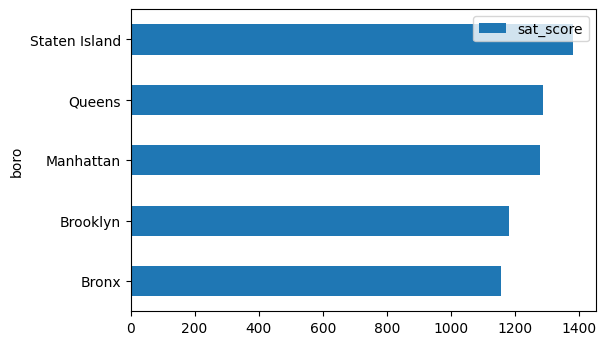

In [63]:
borough_sat_pvt.plot(kind='barh')

In [64]:
school_dist_sat_pvt = pd.pivot_table(combined, values=['sat_score'], index=['boro','school_dist'])
pd.pivot_table(combined, values=['sat_score'], index=['boro','school_dist'])

sat_score
boro          school_dist             
Bronx         07           1128.846154
              08           1159.665129
              09           1131.971940
              10           1222.227273
              11           1165.000000
              12           1101.823134
Brooklyn      13           1237.187600
              14           1179.459915
              15           1190.604312
              16           1120.109701
              17           1161.428571
              18           1118.000000
              19           1103.833333
              20           1273.687761
              21           1206.312619
              22           1450.500000
              23           1157.333333
              32           1119.500000
Manhattan     01           1354.500000
              02           1295.638184
              03           1293.443035
              04           1224.142857
              05           1285.062687
              06           1164.643881
Queens        24           1242.000000
              25           1357.000000
              26           1377.600000
              27           1224.300000
              28           1347.846947
              29           1181.929851
              30           1326.382090
Staten Island 31           1382.500000

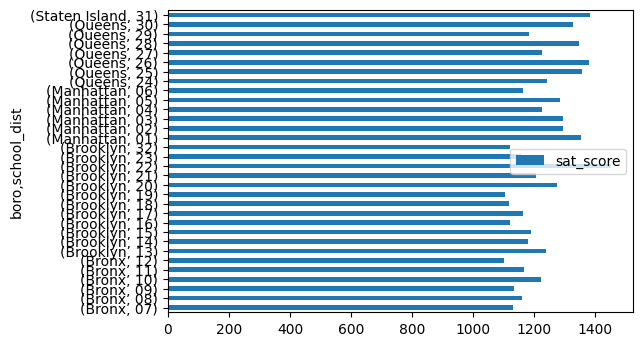

In [66]:
school_dist_sat_pvt.plot(kind='barh',sort_columns = True)

In [67]:
borough_sat_pvt_test = pd.pivot_table(combined, values=['sat_score'], index=['boro'],aggfunc=['count','mean'])
pd.pivot_table(combined, values=['sat_score'], index=['boro'],aggfunc=['count','mean'])

,count,mean
,sat_score,sat_score
boro,,
Bronx,93,1157.598203
Brooklyn,106,1181.364461
Manhattan,90,1278.331410
Queens,64,1286.753032
Staten Island,10,1382.500000
